# Variational Autoencoder

In [1]:
# for local testing
import sys
sys.path.append('../autopandas')

In [2]:
import autopandas as apd
from autopandas.generators.vae import VAE
from autopandas.generators.fae import FAE
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

/usr/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


# MIMIC

In [3]:
# Load MIMIC dataset
train = apd.read_csv('data/mimic_train_sdv.csv') #[:200]
test = apd.read_csv('data/mimic_test_sdv.csv') #[:200]

# Define class
train.set_class('DIED')
test.set_class('DIED')

#data = apd.from_train_test(x_train, x_test)
input_dim = train.shape[1]

In [4]:
train.shape

(13463, 339)

### a. Visualization

In [5]:
train.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0.736841,0.367033,0.178041,0.323594,0.178995,0.685247,0.695830,0.534141,0.007102,0.379733,...,0.566946,0.466166,0.454668,0.508533,0.043820,0.873301,0.439185,0.644301,0.927768,0.340453
1,0.325086,0.344490,0.104803,0.655811,0.783455,0.294163,0.398976,0.406052,0.018570,0.588893,...,0.998080,0.328330,0.248050,0.518272,0.475675,0.437482,0.300124,0.962873,0.200489,0.471393
2,0.365095,0.308756,0.431394,0.867922,0.765800,0.665502,0.799933,0.489344,0.006504,0.401370,...,0.560525,0.360634,0.359545,0.663067,0.062456,0.692662,0.137554,0.629658,0.914016,0.602066
3,0.076284,0.615019,0.186723,0.455209,0.347381,0.288593,0.731176,0.778186,0.010623,0.487919,...,0.513111,0.139621,0.480334,0.286370,0.414262,0.492274,0.865511,0.368510,0.817126,0.514404
4,0.180657,0.602065,0.864738,0.804294,0.297092,0.227642,0.029551,0.576505,0.012278,0.480707,...,0.451776,0.197078,0.419377,0.699087,0.332916,0.565916,0.208199,0.519025,0.823585,0.243542


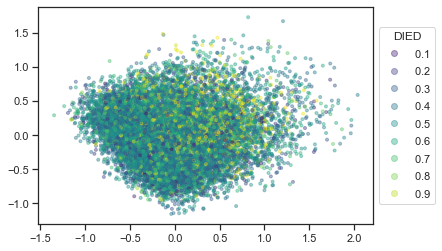

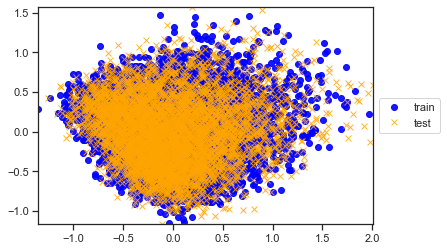

In [13]:
nb_to_plot = min(train.shape[0], 5000)

pca = train.pca(n_components=2).plot(c=train.get_data('y'))

pca_tr, pca_model = train.pca(n_components=2, return_param=True)
pca_tr = pca_tr[:nb_to_plot]
pca_te = test.pca(model=pca_model)[:nb_to_plot]
apd.plot(pca_tr, pca_te, names=['train', 'test'])

In [8]:
train.distance(test)

0

### b. Training

In [6]:
model = apd.generators.VAE(input_dim, latent_dim=8)
vae, encoder, decoder = model.get_autoencoder(), model.get_encoder(), model.get_decoder()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
batch_size=128
epochs=20

columns = train.columns
test_np = test.as_matrix()

model.fit(train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(test_np, test_np))

Instructions for updating:
Use tf.cast instead.
Train on 13463 samples, validate on 13463 samples
Epoch 1/20
13463/13463 [==============================] - 1s 65us/step - loss: 89.0784 - val_loss: 88.6952
Epoch 2/20
13463/13463 [==============================] - 0s 31us/step - loss: 88.2552 - val_loss: 88.4485
Epoch 3/20
13463/13463 [==============================] - 0s 30us/step - loss: 87.8134 - val_loss: 88.1656
Epoch 4/20
13463/13463 [==============================] - 0s 29us/step - loss: 87.5613 - val_loss: 88.0709
Epoch 5/20
13463/13463 [==============================] - 0s 29us/step - loss: 87.3592 - val_loss: 87.6120
Epoch 6/20
13463/13463 [==============================] - 0s 30us/step - loss: 87.2224 - val_loss: 87.3864
Epoch 7/20
13463/13463 [==============================] - 0s 30us/step - loss: 87.0702 - val_loss: 87.1686
Epoch 8/20
13463/13463 [==============================] - 0s 29us/step - loss: 86.9344 - val_loss: 87.0093
Epoch 9/20
13463/13463 [======================

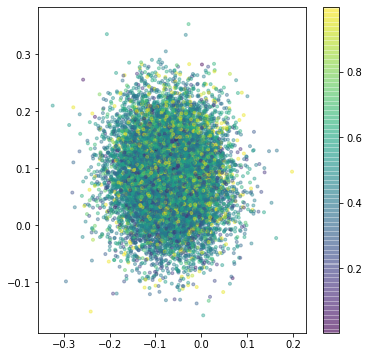

In [9]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(test_np, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.array(test.get_data('y').T).ravel(),
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

### c. Benchmark

In [10]:
# Generate samples
n = test.shape[0]
decoded = model.sample(n, loc=0, scale=6)

In [11]:
decoded.distance(test)

0

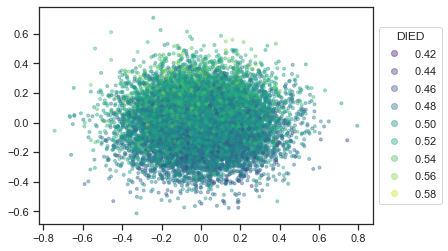

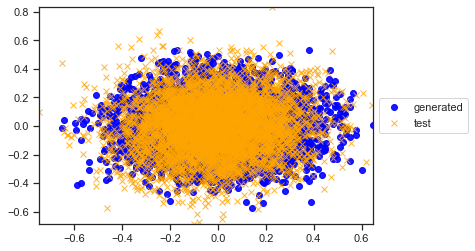

In [14]:
pca = decoded.pca(n_components=2).plot(c=decoded.get_data('y'))

pca_dec, pca_model = decoded.pca(n_components=2, return_param=True)
pca_dec = pca_dec[:nb_to_plot]
pca_te = test.pca(model=pca_model)[:nb_to_plot]
apd.plot(pca_dec, pca_te, names=['generated', 'test'])

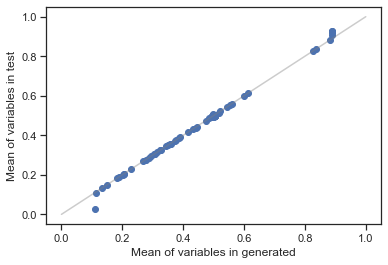

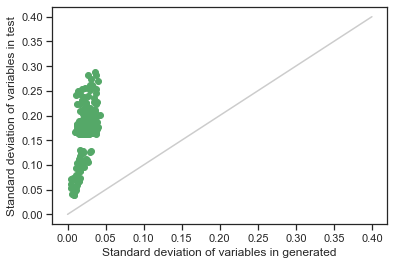

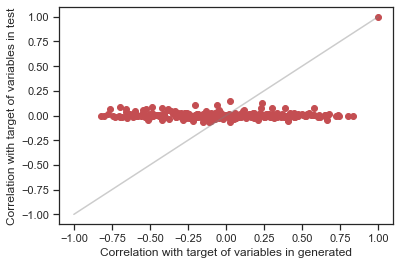

In [15]:
apd.compare_marginals(decoded, test, method='mean', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='std', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='corr', target='DIED', name1='generated', name2='test')

In [16]:
decoded.distance(test, method='discrepancy')

0.9699182966080713

In [17]:
# utility
print(test.score())
print(decoded.score())

-0.035609720278959145
0.9871373499852146


In [150]:
# save generated data
#x_decoded.to_csv('data/mimic_generated_sdv.csv')

In [148]:
# TODO NNAA between latent representation
#decoded_z = encoder.predict(decoded)
#test_z = encoder.predict(test)
#decoded_z.distance(test_z)

# MNIST

In [4]:
from keras.datasets import mnist
from scipy.stats import norm

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
input_dim = 28*28
x_train = x_train.reshape(-1, input_dim) / 255.
x_test = x_test.reshape(-1, input_dim) / 255.

In [24]:
def show(vector, rotation=False):
    vector2d = vector.reshape(28, 28)
    if rotation:
        plt.imshow(np.rot90(vector2d))
    else:
        plt.imshow(vector2d)

# VAE

In [114]:
model = VAE(input_dim, layers=256, latent_dim=2, loss='nll')
vae, encoder, decoder = model.get_autoencoder(), model.get_encoder(), model.get_decoder()

In [115]:
batch_size=100
epochs=10
input_dim = x_train.shape[1]

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 77us/step - loss: 27.1021 - val_loss: 24.4789
Epoch 2/10
60000/60000 [==============================] - 4s 65us/step - loss: 24.4242 - val_loss: 24.1659
Epoch 3/10
60000/60000 [==============================] - 4s 64us/step - loss: 24.1914 - val_loss: 24.0031
Epoch 4/10
60000/60000 [==============================] - 4s 63us/step - loss: 24.0422 - val_loss: 23.9165
Epoch 5/10
60000/60000 [==============================] - 4s 65us/step - loss: 23.9358 - val_loss: 23.8088
Epoch 6/10
60000/60000 [==============================] - 4s 64us/step - loss: 23.8448 - val_loss: 23.7426
Epoch 7/10
60000/60000 [==============================] - 4s 63us/step - loss: 23.7772 - val_loss: 23.6548
Epoch 8/10
60000/60000 [==============================] - 4s 63us/step - loss: 23.7275 - val_loss: 23.6656
Epoch 9/10
60000/60000 [==============================] - 4s 63us/step - loss: 23.6803 - val_l

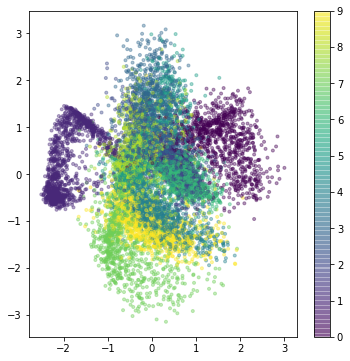

In [116]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 100  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))

#x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)
#plt.figure(figsize=(10, 10))
#plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
#plt.show()

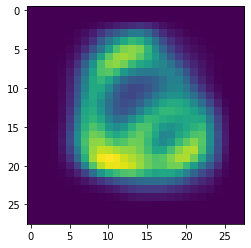

In [119]:
img = np.array(model.sample(n=1))
show(img)

In [36]:
print(x_test.shape)
print(x_decoded.shape)

(10000, 784)
(10000, 784)


/usr/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


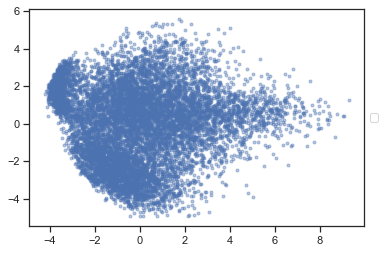

/usr/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


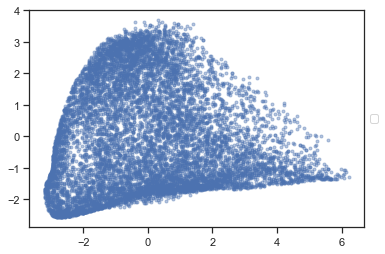

In [124]:
apd.AutoData(x_test).pca(n_components=2).plot()
apd.AutoData(x_decoded).pca(n_components=2).plot()

Issue due to gaussian sampling?

In [37]:
x_test_enc = encoder.predict(x_test)[:1000]
x_decoded_enc = encoder.predict(x_decoded)[:1000]

In [38]:
print(x_test_enc.shape)
print(x_decoded_enc.shape)

(1000, 2)
(1000, 2)


# NNAA between encoded True and Synthetic datasets

* Distance metric should make more sense in latent space than in original space
* Lighter to compute in lower dimensionality

In [39]:
apd.AutoData(x_test_enc).distance(apd.AutoData(x_decoded_enc), method='nnaa')

0.6880000000000001

/usr/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


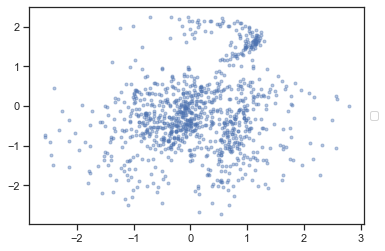

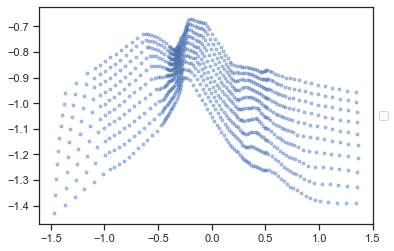

In [40]:
apd.AutoData(x_test_enc).plot()
apd.AutoData(x_decoded_enc).plot()

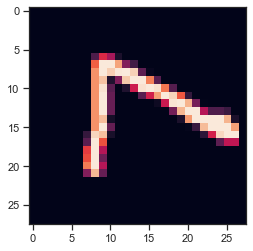

In [41]:
show(x_test[0], rotation=True)

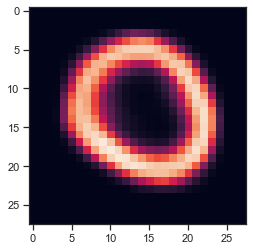

In [42]:
show(x_decoded[0], rotation=True)

# FAE

In [108]:
fae = FAE([input_dim, 256, 2], loss='mse', normalization=False)

In [109]:
fae.fit(x_train, epochs=[20, 40], batch_size=100, validation_data=(x_test, x_test))

Training model 1/2
Input shape: (60000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0191 - val_loss: 0.0070
Epoch 2/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0059 - val_loss: 0.0051
Epoch 3/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 4/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/20
60000/60000 [==============================] - 3s 47us

In [110]:
data = x_train[:1]

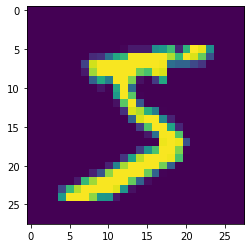

In [111]:
show(data)

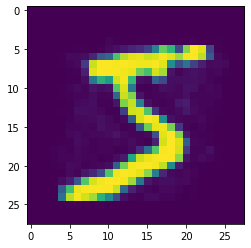

In [112]:
show(fae.models[0].autoencoder.predict(data))

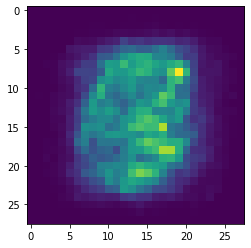

In [113]:
show(fae.autoencode(data))

In [90]:
x_train_enc = fae.models[0].get_encoder().predict(x_train)
x_test_enc = fae.models[0].get_encoder().predict(x_test)
#x_train_enc = fae.encode(x_train)
#x_test_enc = fae.encode(x_test)

In [91]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train_enc, y_train)
clf.score(x_test_enc, y_test)

0.9025